### mdai python API Hello World

In [1]:
import os
import sys
import random
import math
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt

import io
import hashlib 
import json
import pydicom

import tensorflow as tf
from object_detection.utils import dataset_util

In [2]:
#####################################################
### Hack to use mdai client library!! 
import os 
import sys
MODULE_DIR = os.path.abspath('../../mdai-client-py')
print(MODULE_DIR)
sys.path.append(MODULE_DIR) # go to parent dir
#####################################################

/home/txia/mdai-proj/mdai-client-py


In [3]:
from mdai import visualize as vis 
from mdai import preprocess as pps
from mdai import utils 
from mdai import export 

import importlib
importlib.reload(vis)
importlib.reload(pps)
importlib.reload(utils)
importlib.reload(export)

<module 'mdai.export' from '/home/txia/mdai-proj/mdai-client-py/mdai/export.py'>

In [4]:
data_fp = '../data/hello-world/mdai_public_project_PVq9raBJ_dataset_all_labelgroup_all_2018-07-17-101553.json'
image_fp = '../data/hello-world/mdai_public_project_PVq9raBJ_dataset_all_2018-07-17-101532'

p = pps.Project(data_fp, image_fp)

# get labels based on set group 
label_groups = p.get_label_groups()

print('All Label Groups: ')
for label_group in label_groups: 
    print('Name: %s, Id: %s' % (label_group.name, label_group.id))
print('')
    
label_group = p.get_label_group_by_id('G_3lv')
labels = label_group.get_labels()
label_ids = [label[0] for label in labels]
print(labels)

All Label Groups: 
Name: Default group, Id: G_3lv

[('L_yxv', 'Abdomen'), ('L_dyy', 'Chest')]


In [5]:
datasets = p.get_datasets()
len(datasets)
for dataset in datasets: 
    print(dataset.name)

TRAIN
VAL
TEST


In [6]:
# create training dataset 
train_dataset = p.get_dataset_by_name('TRAIN')
train_ann = train_dataset.get_annotations()
train_imgs_anns = train_dataset.associate_images_and_annotations(train_ann, label_ids)
train_image_ids = train_dataset.get_image_ids(train_ann)

# show as a pandas dataframe 
train_ann_df = pd.DataFrame(train_ann); train_ann_df

,SOPInstanceUID,SeriesInstanceUID,StudyInstanceUID,annotationNumber,createdAt,createdById,data,height,id,labelId,machineLearningModelId,note,radlexTagIds,reviewsNegativeCount,reviewsPositiveCount,updatedAt,updatedById,width
0,1.2.276.0.7230010.3.1.4.8323329.15725.15317874...,1.2.276.0.7230010.3.1.3.8323329.15725.15317874...,1.2.276.0.7230010.3.1.2.8323329.15725.15317874...,None,2018-07-17T13:57:17.820Z,U_mom,None,None,A_8rm6gk,L_yxv,None,None,[],0,0,2018-07-17T13:57:17.827Z,U_mom,None
1,1.2.276.0.7230010.3.1.4.8323329.15757.15317874...,1.2.276.0.7230010.3.1.3.8323329.15757.15317874...,1.2.276.0.7230010.3.1.2.8323329.15757.15317874...,None,2018-07-17T13:57:25.409Z,U_mom,None,None,A_d3g9rv,L_yxv,None,None,[],0,0,2018-07-17T13:57:25.415Z,U_mom,None
2,1.2.276.0.7230010.3.1.4.8323329.16092.15317874...,1.2.276.0.7230010.3.1.3.8323329.16092.15317874...,1.2.276.0.7230010.3.1.2.8323329.16092.15317874...,None,2018-07-17T13:57:22.545Z,U_mom,None,None,A_277g0w,L_dyy,None,None,[],0,0,2018-07-17T13:57:22.550Z,U_mom,None
3,1.2.276.0.7230010.3.1.4.8323329.16110.15317874...,1.2.276.0.7230010.3.1.3.8323329.16110.15317874...,1.2.276.0.7230010.3.1.2.8323329.16110.15317874...,None,2018-07-17T13:58:07.424Z,U_mom,None,None,A_277g60,L_dyy,None,None,[],0,0,2018-07-17T13:58:07.429Z,U_mom,None
4,1.2.276.0.7230010.3.1.4.8323329.15727.15317874...,1.2.276.0.7230010.3.1.3.8323329.15727.15317874...,1.2.276.0.7230010.3.1.2.8323329.15727.15317874...,None,2018-07-17T13:58:30.921Z,U_mom,None,None,A_2qn4v4,L_yxv,None,None,[],0,0,2018-07-17T13:58:30.928Z,U_mom,None
5,1.2.276.0.7230010.3.1.4.8323329.16035.15317874...,1.2.276.0.7230010.3.1.3.8323329.16035.15317874...,1.2.276.0.7230010.3.1.2.8323329.16035.15317874...,None,2018-07-17T13:59:17.124Z,U_mom,None,None,A_85n0zq,L_dyy,None,None,[],0,0,2018-07-17T13:59:17.131Z,U_mom,None
6,1.2.276.0.7230010.3.1.4.8323329.15697.15317874...,1.2.276.0.7230010.3.1.3.8323329.15697.15317874...,1.2.276.0.7230010.3.1.2.8323329.15697.15317874...,None,2018-07-17T13:59:41.033Z,U_mom,None,None,A_2og3xe,L_yxv,None,None,[],0,0,2018-07-17T13:59:41.039Z,U_mom,None
7,1.2.276.0.7230010.3.1.4.8323329.15822.15317874...,1.2.276.0.7230010.3.1.3.8323329.15822.15317874...,1.2.276.0.7230010.3.1.2.8323329.15822.15317874...,None,2018-07-17T13:59:42.368Z,U_mom,None,None,A_2ejx40,L_yxv,None,None,[],0,0,2018-07-17T13:59:42.373Z,U_mom,None
8,1.2.276.0.7230010.3.1.4.8323329.15735.15317874...,1.2.276.0.7230010.3.1.3.8323329.15735.15317874...,1.2.276.0.7230010.3.1.2.8323329.15735.15317874...,None,2018-07-17T13:55:27.037Z,U_mom,None,None,A_2w5461,L_dyy,None,None,[],0,0,2018-07-17T13:55:27.042Z,U_mom,None
9,1.2.276.0.7230010.3.1.4.8323329.16090.15317874...,1.2.276.0.7230010.3.1.3.8323329.16090.15317874...,1.2.276.0.7230010.3.1.2.8323329.16090.15317874...,None,2018-07-17T13:55:29.355Z,U_mom,None,None,A_2931p7,L_dyy,None,None,[],0,0,2018-07-17T13:55:29.362Z,U_mom,None


In [7]:
val_dataset = p.get_dataset_by_name('VAL')
val_ann = val_dataset.get_annotations()
val_imgs_anns = train_dataset.associate_images_and_annotations(val_ann, label_ids)
val_image_ids = val_dataset.get_image_ids(val_ann)

# show as a pandas dataframe 
val_ann_df = pd.DataFrame(val_ann); val_ann_df

,SOPInstanceUID,SeriesInstanceUID,StudyInstanceUID,annotationNumber,createdAt,createdById,data,height,id,labelId,machineLearningModelId,note,radlexTagIds,reviewsNegativeCount,reviewsPositiveCount,updatedAt,updatedById,width
0,1.2.276.0.7230010.3.1.4.8323329.15583.15317874...,1.2.276.0.7230010.3.1.3.8323329.15583.15317874...,1.2.276.0.7230010.3.1.2.8323329.15583.15317874...,None,2018-07-17T14:03:43.274Z,U_mom,None,None,A_2vp3xm,L_dyy,None,None,[],0,0,2018-07-17T14:03:43.280Z,U_mom,None
1,1.2.276.0.7230010.3.1.4.8323329.15505.15317874...,1.2.276.0.7230010.3.1.3.8323329.15505.15317874...,1.2.276.0.7230010.3.1.2.8323329.15505.15317874...,None,2018-07-17T14:03:36.134Z,U_mom,None,None,A_277g50,L_yxv,None,None,[],0,0,2018-07-17T14:03:36.142Z,U_mom,None
2,1.2.276.0.7230010.3.1.4.8323329.15506.15317874...,1.2.276.0.7230010.3.1.3.8323329.15506.15317874...,1.2.276.0.7230010.3.1.2.8323329.15506.15317874...,None,2018-07-17T14:03:32.229Z,U_mom,None,None,A_8nyqom,L_dyy,None,None,[],0,0,2018-07-17T14:03:32.235Z,U_mom,None
3,1.2.276.0.7230010.3.1.4.8323329.15586.15317874...,1.2.276.0.7230010.3.1.3.8323329.15586.15317874...,1.2.276.0.7230010.3.1.2.8323329.15586.15317874...,None,2018-07-17T14:03:34.622Z,U_mom,None,None,A_8m6jv6,L_dyy,None,None,[],0,0,2018-07-17T14:03:34.629Z,U_mom,None
4,1.2.276.0.7230010.3.1.4.8323329.15508.15317874...,1.2.276.0.7230010.3.1.3.8323329.15508.15317874...,1.2.276.0.7230010.3.1.2.8323329.15508.15317874...,None,2018-07-17T14:03:41.653Z,U_mom,None,None,A_d3g9ey,L_yxv,None,None,[],0,0,2018-07-17T14:03:41.660Z,U_mom,None
5,1.2.276.0.7230010.3.1.4.8323329.15509.15317874...,1.2.276.0.7230010.3.1.3.8323329.15509.15317874...,1.2.276.0.7230010.3.1.2.8323329.15509.15317874...,None,2018-07-17T14:03:37.860Z,U_mom,None,None,A_20153o,L_dyy,None,None,[],0,0,2018-07-17T14:03:37.867Z,U_mom,None
6,1.2.276.0.7230010.3.1.4.8323329.15512.15317874...,1.2.276.0.7230010.3.1.3.8323329.15512.15317874...,1.2.276.0.7230010.3.1.2.8323329.15512.15317874...,None,2018-07-17T14:03:51.350Z,U_mom,None,None,A_2og3ee,L_yxv,None,None,[],0,0,2018-07-17T14:03:51.357Z,U_mom,None
7,1.2.276.0.7230010.3.1.4.8323329.15507.15317874...,1.2.276.0.7230010.3.1.3.8323329.15507.15317874...,1.2.276.0.7230010.3.1.2.8323329.15507.15317874...,None,2018-07-17T14:03:59.564Z,U_mom,None,None,A_2ejxy0,L_dyy,None,None,[],0,0,2018-07-17T14:03:59.571Z,U_mom,None
8,1.2.276.0.7230010.3.1.4.8323329.15510.15317874...,1.2.276.0.7230010.3.1.3.8323329.15510.15317874...,1.2.276.0.7230010.3.1.2.8323329.15510.15317874...,None,2018-07-17T14:07:03.576Z,U_mom,None,None,A_2kx4l6,L_yxv,None,None,[],0,0,2018-07-17T14:07:03.581Z,U_mom,None
9,1.2.276.0.7230010.3.1.4.8323329.15511.15317874...,1.2.276.0.7230010.3.1.3.8323329.15511.15317874...,1.2.276.0.7230010.3.1.2.8323329.15511.15317874...,None,2018-07-17T14:07:14.582Z,U_mom,None,None,A_81qkx4,L_yxv,None,None,[],0,0,2018-07-17T14:07:14.588Z,U_mom,None


### Based on labels shown above, select several labels to use in filter

(469, 459, 3)


(-0.5, 458.5, 468.5, -0.5)

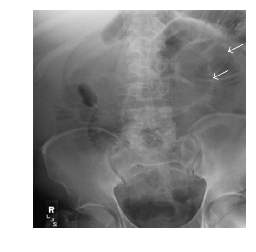

In [8]:
image = vis.load_dicom_image(train_image_ids[0], to_RGB=True)
print(image.shape)
plt.imshow(image)
plt.axis('Off')

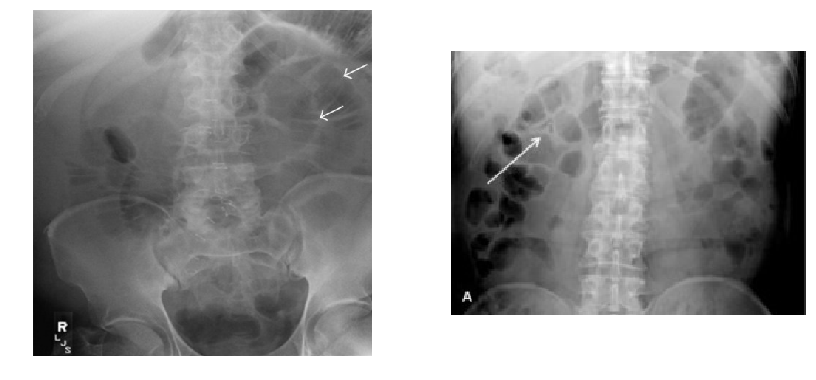

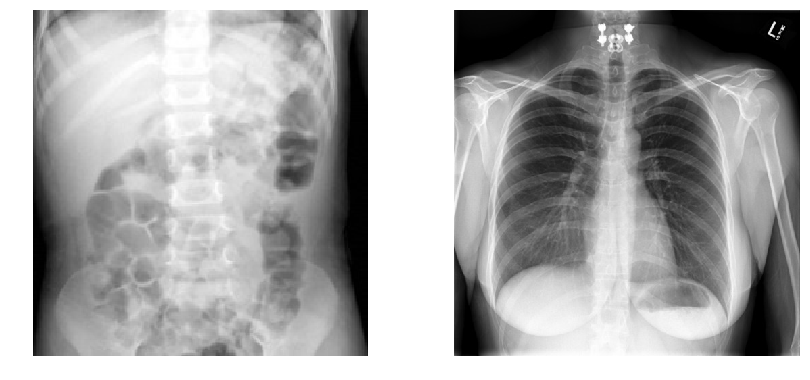

In [9]:
# visualize a few train images 
vis.display_images(train_image_ids[:2], cols=2)
vis.display_images(val_image_ids[:2], cols=2)

In [10]:
#show few entries in images_and_annotations with filled annotations (not null)
# anno_list = []
# for i, uid in enumerate(train_image_ids[:2]):
#     annotations = train_imgs_anns[uid]
#     if annotations: 
#         print('\nann:%s \nuid: %s\n' % (annotations, uid))
#         anno_list.append(annotations)

### Simple Keras generator

In [20]:
from keras.utils import Sequence
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam
import keras 
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Parameters 
img_width = 256
img_height = 256

params = {'dim': (img_width,img_height),
          'batch_size': 5,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True}

In [21]:
# model 
base_model = applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
model_top  = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], data_format=None)),  
model_top.add(Dense(256, activation='relu'))
model_top.add(Dropout(0.5))
model_top.add(Dense(2, activation='softmax')) 

model = Model(inputs=base_model.input, outputs=model_top(base_model.output))

model.compile(optimizer=Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
# label_ids to class_ids 
# [('L_yxv', 'Abdomen'), ('L_dyy', 'Chest')]
def label_id_to_class_id(label_id): 
    if label_id == 'L_yxv': 
        return 0 
    else: 
        return 1 

In [23]:
from skimage.transform import resize

class DataGenerator(Sequence): 
    """Generates data for Keras"""
    ### TODO: 
    #     def __init__(self, dataset, batch_size=32, dim=(32,32,32), n_channels=1,

    def __init__(self, img_ids, imgs_anns, batch_size=32, dim=(32,32), n_channels=1,
                 n_classes=10, shuffle=True):
        #Initialization
        self.dim = dim
        self.batch_size = batch_size
      
        self.img_ids = img_ids
        self.imgs_anns = imgs_anns
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.img_ids) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        img_ids_temp = [self.img_ids[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(img_ids_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.img_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_ids_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(img_ids_temp):
            image = vis.load_dicom_image(ID, to_RGB=True)
            image = resize(image, (self.dim[0],self.dim[1]))
            X[i,] = image

            ann = self.imgs_anns[ID][0]
            y[i] = label_id_to_class_id(ann['labelId'])  
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [24]:
import warnings
warnings.filterwarnings('ignore')

train_generator = DataGenerator(train_image_ids, train_imgs_anns, **params)
val_generator = DataGenerator(val_image_ids, val_imgs_anns, **params)

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

history = model.fit_generator(
            generator=train_generator,
            epochs=20,
            callbacks=callbacks,
            verbose=1,            
            validation_data=val_generator,
            use_multiprocessing=True, 
            workers=6)         

Epoch 1/20
13/13 [==============================] - 39s 3s/step - loss: 0.5172 - acc: 0.7077 - val_loss: 0.1821 - val_acc: 0.9000
Epoch 2/20
13/13 [==============================] - 28s 2s/step - loss: 0.1630 - acc: 0.9385 - val_loss: 0.1667 - val_acc: 0.9000
Epoch 3/20
13/13 [==============================] - 28s 2s/step - loss: 0.0473 - acc: 1.0000 - val_loss: 0.1222 - val_acc: 1.0000
Epoch 4/20
13/13 [==============================] - 28s 2s/step - loss: 0.1844 - acc: 0.9231 - val_loss: 0.1521 - val_acc: 0.9000
Epoch 5/20
13/13 [==============================] - 29s 2s/step - loss: 0.0508 - acc: 0.9846 - val_loss: 0.1628 - val_acc: 0.9000
Epoch 6/20
13/13 [==============================] - 29s 2s/step - loss: 0.1709 - acc: 0.9385 - val_loss: 0.3419 - val_acc: 0.9000
Epoch 7/20
13/13 [==============================] - 29s 2s/step - loss: 0.0974 - acc: 0.9538 - val_loss: 0.2765 - val_acc: 0.8000
Epoch 8/20
13/13 [==============================] - 30s 2s/step - loss: 0.1031 - acc: 0.95

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


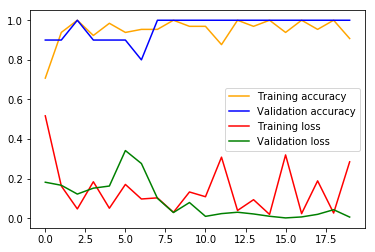

In [25]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

In [26]:
import numpy as np
from keras.preprocessing import image

test_dataset = p.get_dataset_by_name('TEST')
test_ann = test_dataset.get_annotations()
test_imgs_anns = test_dataset.associate_images_and_annotations(test_ann, label_ids)
test_image_ids = train_dataset.get_image_ids(test_ann)

In [31]:
model = keras.models.load_model('best_model.h5')

[[0.01292566 0.9870744 ]] [1]
[[9.9984848e-01 1.5147348e-04]] [0]


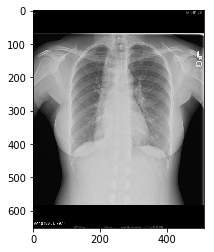

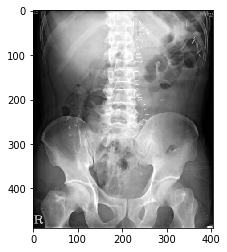

In [35]:
for image_id in test_image_ids: 
    
    image = vis.load_dicom_image(image_id, to_RGB=True)
    plt.figure()
    
    plt.imshow(image)
    
    image = resize(image, (img_width, img_height,3))
    x = np.expand_dims(image, axis=0)
    y_prob = model.predict(x) 
    y_classes = y_prob.argmax(axis=-1)
    print(y_prob, y_classes)
    
plt.show()

# img = image.img_to_array(img)
# x = np.expand_dims(img, axis=0) * 1./255
# score = model.predict(x)
# print('Predicted:', score, 'Chest X-ray' if score < 0.5 else 'Abd X-ray')

# plt.imshow(img2)
# plt.show()

# img2 = image.img_to_array(img2)
# x = np.expand_dims(img2, axis=0) * 1./255
# score2 = model.predict(x)
# print('Predicted:', score2, 'Chest X-ray' if score2 < 0.5 else 'Abd X-ray')